In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from res_manager import ResultManager

In [3]:
rm = ResultManager('evaluation_results')

In [4]:
rm.print_meta_info()

+---------+------------------------------+-------------+-------------+----------+
| Data ID |             Name             |    Topic    |     Type    | Versions |
+---------+------------------------------+-------------+-------------+----------+
|    1    | Robustness_JPEG_InceptionV3  |   Dataset   | defaultdict |    1     |
|    2    | Performance_JPEG_InceptionV3 | Performance | defaultdict |    1     |
|    3    |  Banchmark_JPEG_InceptionV3  |  Banchmark  | defaultdict |    1     |
|    4    |   Banchmark_JPEG_ResNet50    |  Banchmark  | defaultdict |    2     |
|    5    |   Robustness_JPEG_ResNet50   |   Dataset   | defaultdict |    1     |
+---------+------------------------------+-------------+-------------+----------+


# Performance on JPEG and InceptionV3

In [5]:
accuracies = rm.load(3)['accuracies']
sizes = rm.load(3)['sizes']
qualities = rm.load(3)['qualities']
errors = 1. - np.array(accuracies)

In [6]:
performance = rm.load(2)

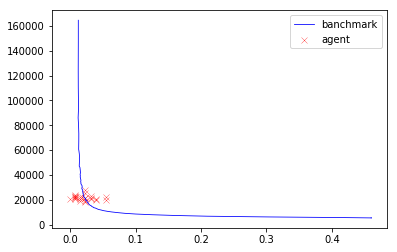

In [7]:
plot(errors, sizes, c='b', linewidth=0.8, label="banchmark")
scatter(1. - np.array(performance['batch_accuracies']), performance['batch_sizes'], marker='x', linewidth=0.3, c='r', label='agent')
legend()

In [8]:
performance.keys()

dict_keys(['banchmark_sizes', 'agent_sizes', 'batch_accuracies', 'batch_sizes'])

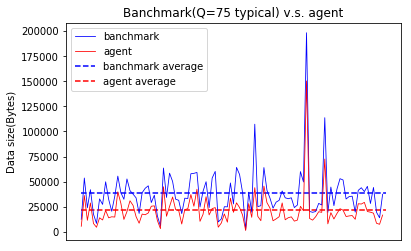

In [9]:
plot_count = 100
plot(performance['banchmark_sizes'][:plot_count], c='b', linewidth=0.8, label='banchmark')
plot(performance['agent_sizes'][:plot_count], c='r', linewidth=0.8, label='agent')
hlines(xmin=0, xmax=plot_count, y=np.mean(performance['banchmark_sizes']), color='b', linestyles='--', label="banchmark average")
hlines(xmin=0, xmax=plot_count, y=np.mean(performance['agent_sizes']), color='r', linestyles='--', label="agent average")
title("Banchmark(Q=75 typical) v.s. agent")
ylabel("Data size(Bytes)")
xticks([])
legend()

In [10]:
print(np.mean(performance['batch_accuracies']))

0.9777715773809524


# Generate banchmark & robustness training set

In [5]:
from keras.applications import ResNet50
from keras.utils.np_utils import to_categorical
from imagenet import imagenet_label2class
from keras.applications.resnet50 import preprocess_input
import os
from io import BytesIO
from collections import defaultdict
from PIL import Image

Using TensorFlow backend.


In [6]:
def gen_sample_set(imagenet_data_path, samples_per_class):
    image_paths = []
    image_labels = []

    img_classes = os.listdir(imagenet_data_path)
    for img_class in img_classes:
        for image_name in np.random.choice(os.listdir("%s/%s" % (imagenet_data_path, img_class)),
                                           size=samples_per_class):
            sample_image_path = ("%s/%s/%s" % (imagenet_data_path, img_class, image_name))
            image_label = imagenet_label2class[image_name.split('_')[0]]

            image_paths.append(sample_image_path)
            image_labels.append(image_label)
    return image_paths, image_labels

def compress_Q(img, Q):
    f = BytesIO()
    img.save(f, format="JPEG", quality=Q)
    size = len(f.getvalue())
    return Image.open(f), size

def max_continous_idx(l):
    sums = []
    ids = []
    curr_sum = 0
    for idx, item in enumerate(l):
        if item == 1:
            curr_sum += 1
            if curr_sum == len(l):
                return len(l) - 1
        else:
            sums.append(curr_sum)
            curr_sum = 0
            ids.append(idx -  1)
    return np.array(ids)[np.argmax(sums)]

In [7]:
sample_paths, sample_labels = gen_sample_set('/home/hsli/gnode02/imagenet-data/train/', 5)

In [8]:
model_labels = to_categorical(sample_labels, 1000)

In [9]:
model = ResNet50()
model.compile('adam', 'categorical_crossentropy', ['top_k_categorical_accuracy'])

In [10]:
robust_dict = defaultdict(list)
measurement_dict = defaultdict(list)
banchmark = defaultdict(list)
for idx, path in enumerate(sample_paths):
    if idx % 100 == 0:
        print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), end='\t')
        print(idx)
    model_label = np.expand_dims(model_labels[idx], axis=0)
    top5_list = []
    size_list = []
    img = Image.open(path).convert("RGB")
    for i in arange(100, 0, -1):
        compressed_img, size = compress_Q(img, int(i))
        model_input_data = preprocess_input(np.expand_dims(np.asarray(compressed_img.resize((224, 224)), dtype=np.float32), axis=0))
        loss, top5 = model.evaluate(model_input_data, model_label, verbose=0)
        top5_list.append(int(top5))
        size_list.append(size)
    minimal_stable_q = 100 - max_continous_idx(top5_list)
    measurement_dict['paths'].append(path)
    measurement_dict['top5_upon_q'].append(top5_list)
    measurement_dict['minimal_stable_q'].append(minimal_stable_q)
    measurement_dict['size_lists'].append(size_list)
    
    if minimal_stable_q < 100:
        robust_dict['paths'].append(path)
        robust_dict['robustness'].append(minimal_stable_q)
    

2019-03-04 21:53:46	0
2019-03-04 21:57:43	100
2019-03-04 22:01:34	200
2019-03-04 22:05:19	300
2019-03-04 22:09:21	400
2019-03-04 22:13:22	500
2019-03-04 22:17:50	600
2019-03-04 22:21:47	700
2019-03-04 22:25:40	800
2019-03-04 22:29:29	900
2019-03-04 22:33:05	1000
2019-03-04 22:37:05	1100
2019-03-04 22:41:04	1200
2019-03-04 22:44:46	1300
2019-03-04 22:49:05	1400
2019-03-04 22:52:47	1500
2019-03-04 22:56:50	1600
2019-03-04 23:01:13	1700
2019-03-04 23:05:00	1800
2019-03-04 23:09:00	1900
2019-03-04 23:12:53	2000
2019-03-04 23:17:17	2100
2019-03-04 23:21:04	2200
2019-03-04 23:24:51	2300
2019-03-04 23:29:05	2400
2019-03-04 23:32:52	2500
2019-03-04 23:37:12	2600
2019-03-04 23:40:59	2700
2019-03-04 23:44:51	2800
2019-03-04 23:48:32	2900
2019-03-04 23:52:29	3000
2019-03-04 23:56:16	3100
2019-03-05 00:00:28	3200
2019-03-05 00:04:12	3300
2019-03-05 00:08:04	3400
2019-03-05 00:12:24	3500
2019-03-05 00:16:42	3600
2019-03-05 00:20:27	3700
2019-03-05 00:24:21	3800
2019-03-05 00:28:08	3900
2019-03-05 0

In [11]:
top5_data = np.array(measurement_dict['top5_upon_q'])
top5_upon_q_list = []
for i in range(100):
    top5_upon_q_list.append(sum(top5_data[:, i]) / len(top5_data[:, i]))

In [12]:
banchmark['accuracies'] = top5_upon_q_list[::-1]
banchmark['qualities'] = [i+1 for i in range(100)]
banchmark['sizes'] = np.mean(np.array(measurement_dict['size_lists']), axis=0)[::-1].tolist()

In [13]:
rm.save(banchmark, name="Banchmark_JPEG_ResNet50", topic="Banchmark", comment="accuracies and sizes upon each Q, JPEG and ResNet50 on 5K")

In [14]:
rm.save(robust_dict, name="Robustness_JPEG_ResNet50", topic="Dataset", comment="robust dataset for JPEG and ResNet50(top-5)")

# Time evaluation

In [26]:
from keras.applications import MobileNetV2

In [27]:
model = MobileNetV2()

In [28]:
start = time.time()

In [29]:
def inference():
    for i in range(10):
        model.predict(np.ones((1, 224, 224, 3)))
    print(time.time() - start)

In [30]:
%time inference()

11.993841409683228
CPU times: user 1.25 s, sys: 3.75 ms, total: 1.25 s
Wall time: 1.24 s


In [20]:
from keras.applications import InceptionV3

In [21]:
model = InceptionV3()

In [22]:
start = time.time()

In [24]:
def inference():
    for i in range(10):
        model.predict(np.ones((1, 224, 224, 3)))
    print(time.time() - start)

In [25]:
%time inference()

30.906505823135376
CPU times: user 212 ms, sys: 40.8 ms, total: 253 ms
Wall time: 231 ms


# Epsilon decay curve

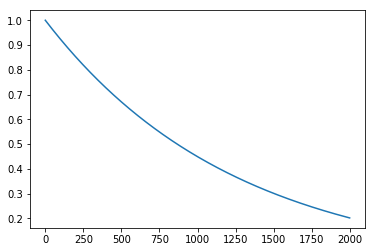

In [15]:
plot([0.9992 ** i for i in range(2000)])

# Does the micro acc_r indicates the macro accuracy?

In [5]:
# encoding: utf-8
import tensorflow as tf
from res_manager import ResultManager
import numpy as np
from collections import defaultdict

from keras.applications.mobilenetv2 import preprocess_input
from keras.applications import InceptionV3

from Agents import DDPG_Agent, Q_Agent
from keras.models import load_model
from ImageCompressionEnvironment import Environment

np.set_printoptions(precision=3)

tf.set_random_seed(2)
np.random.seed(2)

Using TensorFlow backend.


In [6]:
images_dir = '/home/hsli/imagenet-data/train/'

feature_extractor = load_model(
    'checkpoints/mobilenetv2_predictor_2W_acc_0.6955_epoch50.hdf5')

rm = ResultManager('results')
agent_acc_size_dict = []
origin_acc_size_dict = []

agent = Q_Agent(s_dim=2,
                a_dim=10,
                epsilon_decay=0.9993,
                epsilon_min=0.2,
                lr=0.1,
                gamma=0.95)

step_count = 0

env = Environment(imagenet_train_path=images_dir,
                  samples_per_class=1000,
                  backbone_model=InceptionV3(),
                  backbone_model_input_size=(299, 299))

1000/1000 [==============================] - 8s 8ms/step
Reference soft labels generated..


In [7]:
from collections import defaultdict

In [8]:
result = defaultdict(list)
for idx, image in enumerate(env.image_datalist):
    print(idx, end=', ')
    accr_list = []
    sizer_list = []
    for q in np.arange(100, 0, -1):
        acc_r, size_r = env.model_recognize(image, 
                                            int(q),
                                            env.label_datalist[idx],
                                            env.ref_softlabels[idx],
                                            env.ref_size_list[idx])
        accr_list.append(acc_r)
        sizer_list.append(size_r)
    result['acc'].append(accr_list)
    result['size'].append(sizer_list)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 

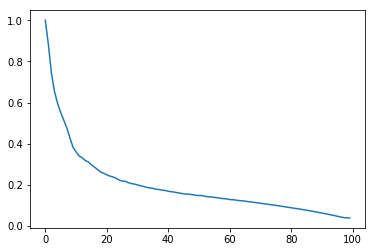

In [9]:
plot(np.mean(np.array(result['size']), axis=0))

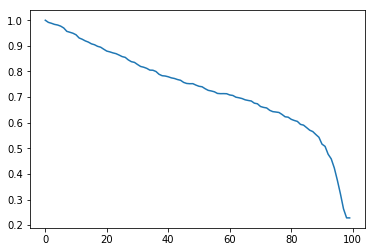

In [13]:
plot(np.mean(np.array(result['acc']), axis=0))

In [14]:
np.mean(np.array(result['acc']), axis=0)

array([1.   , 0.992, 0.988, 0.984, 0.981, 0.977, 0.97 , 0.957, 0.953,
       0.949, 0.943, 0.931, 0.926, 0.919, 0.915, 0.908, 0.904, 0.898,
       0.895, 0.887, 0.88 , 0.877, 0.873, 0.87 , 0.864, 0.858, 0.855,
       0.845, 0.838, 0.835, 0.827, 0.82 , 0.817, 0.812, 0.805, 0.805,
       0.8  , 0.789, 0.783, 0.782, 0.779, 0.775, 0.773, 0.769, 0.766,
       0.757, 0.753, 0.752, 0.752, 0.747, 0.742, 0.74 , 0.733, 0.726,
       0.724, 0.721, 0.714, 0.713, 0.714, 0.713, 0.708, 0.706, 0.7  ,
       0.697, 0.694, 0.689, 0.687, 0.685, 0.676, 0.674, 0.663, 0.66 ,
       0.658, 0.648, 0.643, 0.642, 0.64 , 0.632, 0.623, 0.622, 0.613,
       0.609, 0.605, 0.593, 0.59 , 0.581, 0.571, 0.565, 0.554, 0.543,
       0.516, 0.508, 0.477, 0.459, 0.424, 0.375, 0.322, 0.264, 0.228,
       0.228], dtype=float32)